#Instalações

In [ ]:
!pip install super-gradients==3.1.0
!pip install imutils

!pip install roboflow

!pip install pytube --upgrade
!pip install super_gradients

In [ ]:
import torch
torch.__version__

In [ ]:
torch.cuda.get_device_name(0)

#Importações

In [ ]:
from super_gradients.training.losses import PPYoloELoss
from super_gradients.training.metrics import DetectionMetrics_050
from super_gradients.training.models.detection_models.pp_yolo_e import PPYoloEPostPredictionCallback
from super_gradients.training import models
from super_gradients.training import dataloaders
from super_gradients.training.dataloaders.dataloaders import coco_detection_yolo_format_train, coco_detection_yolo_format_val
from super_gradients.training import models
from super_gradients.training import Trainer
from roboflow import Roboflow
from google.colab import drive
drive.mount('/content/drive')

# Dataset

In [ ]:

rf = Roboflow(api_key="U5gbzdWetbtq8bQEC1Oj")
project = rf.workspace("roboflow-universe-projects").project("fall-detection-ca3o8")
dataset = project.version(4).download("yolov5")

# Preparando o dataset

In [ ]:
CHECKPOINT_DIR = '/content/drive/MyDrive/checkpoints' # Diretório onde ficarão os checkpoints
trainer = Trainer(experiment_name='my_first_yolonas_run', ckpt_root_dir=CHECKPOINT_DIR)

In [ ]:
dataset_params = {
    'data_dir':'FallDetection',
    'train_images_dir':'train/images',
    'train_labels_dir':'train/labels',
    'val_images_dir':'valid/images',
    'val_labels_dir':'valid/labels',
    'test_images_dir':'test/images',
    'test_labels_dir':'test/labels',
    'classes': ['Fall-Detected']
}

In [ ]:
train_data = coco_detection_yolo_format_train(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['train_images_dir'],
        'labels_dir': dataset_params['train_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size':16,
        'num_workers':2
    }
)

val_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['val_images_dir'],
        'labels_dir': dataset_params['val_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size':16,
        'num_workers':2
    }
)

test_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['test_images_dir'],
        'labels_dir': dataset_params['test_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size':16,
        'num_workers':2
    }
)

#Model

In [ ]:
model = models.get('yolo_nas_l',
                   num_classes=len(dataset_params['classes']),
                   pretrained_weights="coco"
                   )

### 🚨 Alguns dos parâmetros que podem ser definidos 🚨

- `max_epochs` - Max number of training epochs

- `loss` - the loss function you want to use

- `optimizer` - Optimizer you will be using

- `train_metrics_list` - Metrics to log during training

- `valid_metrics_list` - Metrics to log during training

- `metric_to_watch` - metric which the model checkpoint will be saved according to

You can choose from a variety of `optimizer`'s such as: Adam, AdamW, SGD, Lion, or RMSProps. If you choose to change the defualt parameters of these optimizrs you pass them into `optimizer_params`.

In [ ]:
train_params = {
    'silent_mode': False,
    "average_best_models":True,
    "warmup_mode": "linear_epoch_step",
    "warmup_initial_lr": 1e-6,
    "lr_warmup_epochs": 3,
    "initial_lr": 5e-4,
    "lr_mode": "cosine",
    "cosine_final_lr_ratio": 0.1,
    "optimizer": "Adam",
    "optimizer_params": {"weight_decay": 0.0001},
    "zero_weight_decay_on_bias_and_bn": True,
    "ema": True,
    "ema_params": {"decay": 0.9, "decay_type": "threshold"},
    "max_epochs": 12,
    "mixed_precision": True,
    "loss": PPYoloELoss(
        use_static_assigner=False,
        # NOTE: num_classes needs to be defined here
        num_classes=len(dataset_params['classes']),
        reg_max=16
    ),
    "valid_metrics_list": [
        DetectionMetrics_050(
            score_thres=0.1,
            top_k_predictions=300,
            # NOTE: num_classes needs to be defined here
            num_cls=len(dataset_params['classes']),
            normalize_targets=True,
            post_prediction_callback=PPYoloEPostPredictionCallback(
                score_threshold=0.01,
                nms_top_k=1000,
                max_predictions=300,
                nms_threshold=0.7
            )
        )
    ],
    "metric_to_watch": 'mAP@0.50'
}

In [ ]:
trainer.train(model=best_model,
              training_params=train_params,
              train_loader=train_data,
              valid_loader=val_data)

The console stream is now moved to /content/drive/MyDrive/checkpoints/my_first_yolonas_run/console_Aug18_20_02_23.txt


[2023-08-18 20:02:24] INFO - sg_trainer.py - Using EMA with params {'decay': 0.9, 'decay_type': 'threshold'}
[2023-08-18 20:02:29] INFO - sg_trainer_utils.py - TRAINING PARAMETERS:
    - Mode:                         Single GPU
    - Number of GPUs:               1          (1 available on the machine)
    - Dataset size:                 9438       (len(train_set))
    - Batch size per GPU:           16         (batch_size)
    - Batch Accumulate:             1          (batch_accumulate)
    - Total batch size:             16         (num_gpus * batch_size)
    - Effective Batch size:         16         (num_gpus * batch_size * batch_accumulate)
    - Iterations per epoch:         589        (len(train_loader))
    - Gradient updates per epoch:   589        (len(train_loader) / batch_accumulate)

[2023-08-18 20:02:29] INFO - sg_trainer.py - Started training for 2 epochs (0/1)

Validating: 100%|██████████| 57/57 [00:40<00:00,  1.40it/s]
[2023-08-18 20:17:59] INFO - base_sg_logger.py - 

SUMMARY OF EPOCH 0
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.2013
│   ├── Ppyoloeloss/loss_iou = 0.1898
│   ├── Ppyoloeloss/loss_dfl = 1.4427
│   └── Ppyoloeloss/loss = 2.3971
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.3344
    ├── Ppyoloeloss/loss_iou = 0.2142
    ├── Ppyoloeloss/loss_dfl = 1.6168
    ├── Ppyoloeloss/loss = 2.6783
    ├── Precision@0.50 = 0.0156
    ├── Recall@0.50 = 0.99
    ├── Map@0.50 = 0.5156
    └── F1@0.50 = 0.0307



Validating epoch 1: 100%|██████████| 57/57 [00:39<00:00,  1.43it/s]
[2023-08-18 20:33:44] INFO - base_sg_logger.py - Checkpoint saved in /content/drive/MyDrive/checkpoints/my_first_yolonas_run/ckpt_best.pth
[2023-08-18 20:33:44] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.5544266104698181


SUMMARY OF EPOCH 1
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.2405
│   │   ├── Epoch N-1      = 1.2013 (↗ 0.0392)
│   │   └── Best until now = 1.2013 (↗ 0.0392)
│   ├── Ppyoloeloss/loss_iou = 0.1921
│   │   ├── Epoch N-1      = 0.1898 (↗ 0.0023)
│   │   └── Best until now = 0.1898 (↗ 0.0023)
│   ├── Ppyoloeloss/loss_dfl = 1.4698
│   │   ├── Epoch N-1      = 1.4427 (↗ 0.0271)
│   │   └── Best until now = 1.4427 (↗ 0.0271)
│   └── Ppyoloeloss/loss = 2.4556
│       ├── Epoch N-1      = 2.3971 (↗ 0.0585)
│       └── Best until now = 2.3971 (↗ 0.0585)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.286
    │   ├── Epoch N-1      = 1.3344 (↘ -0.0484)
    │   └── Best until now = 1.3344 (↘ -0.0484)
    ├── Ppyoloeloss/loss_iou = 0.2261
    │   ├── Epoch N-1      = 0.2142 (↗ 0.012)
    │   └── Best until now = 0.2142 (↗ 0.012)
    ├── Ppyoloeloss/loss_dfl = 1.6876
    │   ├── Epoch N-1      = 1.6168 (↗ 0.0708)
    │   └── Best until now = 1.6168 (↗ 0.0708)
    ├── Ppyoloeloss/loss = 2.6952
   

[2023-08-18 20:33:53] INFO - sg_trainer.py - RUNNING ADDITIONAL TEST ON THE AVERAGED MODEL...
Validating epoch 2: 100%|██████████| 57/57 [00:44<00:00,  1.29it/s]


# 🏆 Get the best trained model

In [ ]:
best_model = models.get('yolo_nas_l',
                        num_classes=len(dataset_params['classes']),
                        checkpoint_path="/content/drive/MyDrive/checkpoints/my_first_yolonas_run/ckpt_best.pth")

# 🧐 Evaluating the best trained model on the test set

In [ ]:
trainer.test(model=best_model,
            test_loader=test_data,
            test_metrics_list=DetectionMetrics_050(score_thres=0.1,
                                                   top_k_predictions=300,
                                                   num_cls=len(dataset_params['classes']),
                                                   normalize_targets=True,
                                                   post_prediction_callback=PPYoloEPostPredictionCallback(score_threshold=0.01,
                                                                                                          nms_top_k=1000,
                                                                                                          max_predictions=300,
                                                                                                          nms_threshold=0.7)
                                                  ))

Testing:  97%|█████████▋| 28/29 [00:19<00:00,  1.58it/s]

{'Precision@0.50': 0.019999999552965164,
 'Recall@0.50': 0.9777777791023254,
 'mAP@0.50': 0.599164605140686,
 'F1@0.50': 0.039198219776153564}

Testing: 100%|██████████| 29/29 [00:20<00:00,  1.42it/s]


# 🔮 Predicting with the best model


[2023-08-18 20:39:04] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


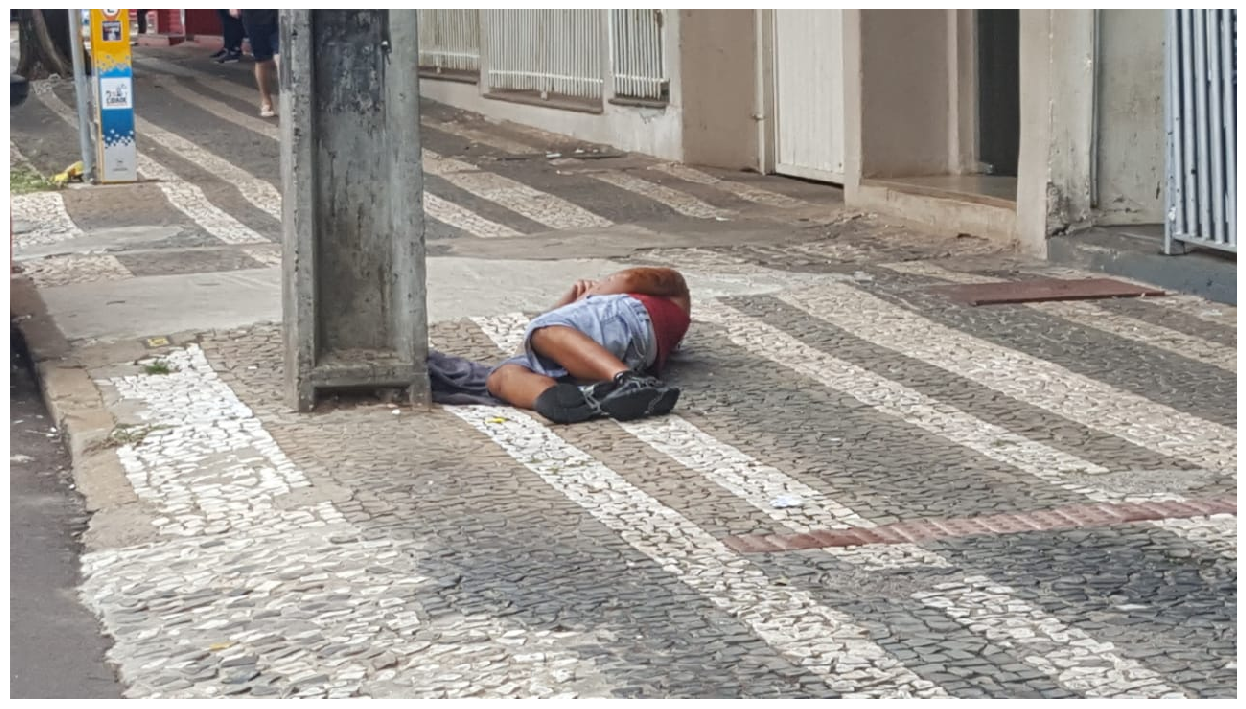

In [ ]:
#img_url = 'https://www.mynumi.net/media/catalog/product/cache/2/image/9df78eab33525d08d6e5fb8d27136e95/s/e/serietta_usa_2_1/www.mynumi.net-USASE5AD160-31.jpg'
#best_model.predict(img_url).show()

test_image = 'queda.jpeg'
best_model.predict(test_image).show()

# 🎥 Inference on video

In [ ]:
import torch
device = 0 if torch.cuda.is_available() else "cpu"

input_video_path = "/content/fall-01-cam0 (online-video-cutter.com).mp4"
output_video_path = "detections.mp4"
#device=0

best_model.to(device).predict(input_video_path).save(output_video_path)

Predicting Video: 100%|██████████| 160/160 [00:03<00:00, 49.40it/s]
